In [81]:
import os
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
import random
import torch

In [2]:
src1 = "dataset/frlg/"
src2 = "dataset/frlg_cont/"

dst = "dataset/frlg_hue/"
os.makedirs(dst, exist_ok=True)

imgs = os.listdir(src1)
if "back" in imgs:
    imgs.remove("back")

random.shuffle(imgs)

for i in imgs:
    toTensor = transforms.ToTensor()
    img = Image.open(src1 + i)
    img_rgb = toTensor(img.convert("RGBA"))
    img_hsv = toTensor(img.convert("HSV"))

    con = Image.open(src2 + i)
    con = toTensor(con.convert("L"))

    white = (img_hsv[[1]] < 0.1).float()
    black = (img_hsv[[2]] < 0.1).float()
    gray = white * (img_hsv[[2]] < 0.5).float()

    img_hsv[[1]] = 0.8
    img_hsv[[2]] = 0.8

    alpha = img_rgb[[3]]

    conv1 = transforms.ToPILImage(mode="HSV")
    img_rgb = toTensor(conv1(img_hsv).convert("RGB"))

    img_rgb += white
    img_rgb = img_rgb.clamp(0,1)

    img_rgb -= gray / 2
    img_rgb = img_rgb.clamp(0,1)

    img_rgb -= black
    img_rgb = img_rgb.clamp(0,1)

    img_rgb -= con
    img_rgb = img_rgb.clamp(0,1)

    img_rgb += (1-alpha)
    img_rgb = img_rgb.clamp(0,1)

    conv2 = transforms.ToPILImage(mode="RGB")
    conv2(img_rgb).save(dst + i)


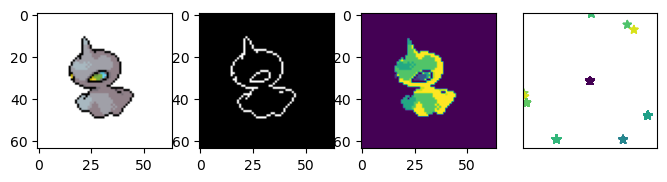

In [238]:
src1 = "dataset/frlg/"
src2 = "dataset/frlg_cont/"

dst = "dataset/frlg_hue/"
os.makedirs(dst, exist_ok=True)

imgs = os.listdir(src1)
if "back" in imgs:
    imgs.remove("back")

random.shuffle(imgs)


for i in imgs:
    toTensor = transforms.ToTensor()
    img = Image.open(src1 + i)
    img_rgb = toTensor(img.convert("RGBA"))
    img_hsv = toTensor(img.convert("HSV"))

    alpha = img_rgb[[3]]
    img_rgb = img_rgb[[0,1,2]]
    img_rgb = img_rgb + (1 - alpha)
    img_rgb = img_rgb.clamp(0,1)

    con = Image.open(src2 + i)
    con = toTensor(con.convert("L"))[0]

    img_rgb = (img_rgb - con).clamp(0,1)

    hue = img_hsv[0]
    hue = (hue - con).clamp(0,1)
    hue = (hue - (1 - alpha[0])).clamp(0,1)

    zr = (hue <= 0).float()

    hue_xy = hue * torch.pi * 2
    hue_xy = torch.stack([torch.cos(hue_xy), torch.sin(hue_xy), img_hsv[2]], dim=0)
    hue_xy *= (1 - zr)
    hue_xy = hue_xy.flatten(start_dim=1)

    fig, axes = plt.subplots(1, 4, figsize=(8, 5))
    axes[0].imshow(img_rgb.permute(1,2,0))
    axes[1].imshow(con, cmap="gray")
    axes[2].imshow(hue)
    axes[3].scatter(hue_xy[0], hue_xy[1], vmin=0, vmax=1, marker="*", c=hue_xy[2])
    axes[3].set_box_aspect(1)
    axes[3].set_xlim(-1, 1)
    axes[3].set_ylim(-1, 1)
    axes[3].xaxis.set_visible(False)
    axes[3].yaxis.set_visible(False)
    plt.show()

    break